In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import jit, int32, float64, float32

# Indlæsning af data

Al data indlæses og slices som vi har gjort tidligere:)

Temperaturer

In [2]:
%%time

rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
print(rådata)
data = rådata.to_numpy()
år, temperatur = data[:,0], data[:,1]
# Tid uden njit: 5.05 s


               Yr       Temp  Completeness
0       1873.0000 -20.131622             2
1       1873.0014 -12.826645             2
2       1873.0027 -20.587018             2
3       1873.0041 -12.755726             2
4       1873.0055 -21.348169             2
...           ...        ...           ...
108109  2020.9932  -3.317742             0
108110  2020.9945  -4.417742             0
108111  2020.9959   1.182258             0
108112  2020.9973   0.000000             0
108113  2020.9986   0.000000             0

[108114 rows x 3 columns]
CPU times: total: 10.1 s
Wall time: 11.7 s


Satellitdata

In [3]:
råsatellit = pd.read_csv('GIS00_grace.dat', delimiter = ' ', header = None)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

Slicing af temperaturdata

In [26]:
top = max(år_sat)   
bund = min(år_sat)
temp = temperatur[(år <= top) & (år >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
årstal = år[(år <= top) & (år >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

[2002.2909 2002.2923 2002.2936 ... 2020.4565 2020.4579 2020.4593]


Nedbørsdata

In [5]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]

In [6]:
# Gennemsnit af nedbør for GRIP og NGRIP over de seneste 20 år af dataserien

akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


# Nedbørskonstanten korrigeres

Simuleringen køres med begge konstanter lig 1, og det samlede volumen undersøges. Herefter bestemmes det brøkforhold, som skal til for at opnå det forventede volumen.

In [47]:
V_start = 2.85 * 10**15   # startvolumen af iskappe
V_sat = dvol_sat + V_start - dvol_sat[0]
V = V_start  # startvolumen af iskappe
V_0 = V_start 
V_sat = dvol_sat + V_0 - dvol_sat[0]
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 2)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
# k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
# På et år smelter ca. 10 cm ned 
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
k_acc = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
k_melt = 1

# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(len(årstal)):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[i] - T_f <= 0:
        V_melt = 0
    elif temp[i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[i] - T_f) * ((T_f - temp[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
    V += V_acc - V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)
    
V_sum = np.sum(V_acc_list)/(årstal[-1] - årstal[0])
V_forventet = (642 * 10**12)/(densitet_is) #m^3

k_acc = V_forventet/V_sum
print('k_acc =', k_acc)

k_acc = 2.255924348249477


# Manuel fitting med chi-kvadrat

Jeg starter med at flitte arrays

In [57]:
årstal_flip = np.flip(årstal)
år_sat_flip = np.flip(år_sat)
temp_flip = np.flip(temp)
V_sat_err_flip = np.flip(V_sat_err)
dvol_sat_flip = np.flip(dvol_sat)

Funktion, som tager k-melt-værdi, og retunerer chi-kvadratet for simuleringen, defineres. Simuleringen kører som vi kender den. Værdierne fra simuleringen interpoleres før der beregnes reduceret chi-kvadrat

In [58]:
V_start = 2.85 * 10**15   # startvolumen af iskappe
V_sat = dvol_sat + V_start - dvol_sat[0]
V_sat_flip = np.flip(V_sat)

def simulering(temp_list, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    h = 3 * 10**3       # Starthøjde af iskappe
    R = 500 * 10**3     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 2)  # Tidsskridt (her 1/2 døgn) - omregnet til år
    
    # Tuningskonstanter
    # k_melt = 8.4 * 10**(-1)   # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
    # På et år smelter ca. 10 cm ned 
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(len(årstal_flip)):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_list[i] - T_f <= 0:
            V_melt = 0
        elif temp_list[i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_list[i] - T_f) * ((T_f - temp_list[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V += - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
        
    V_interpol = np.interp(år_sat_flip, årstal_flip, V_list)   # Interpolering
    
    chi_red = np.sum((V_interpol - V_sat_flip)**2/(V_sat_err_flip)**2)
          
    return chi_red

Jeg definerer nu en funktion, som tager det interval, som vi vil undersøge k-melt for, og hvor fin en opløsning vi vil have, og retunerer den optimale k-melt-værdi. Det gør den ved at køre simulerings-funktionen for alle k-værdierne og retunere den k-værdi, som gav den mindste reducerede chi-kvadrat.

In [59]:
%%time
def optimering(gæt_start, gæt_slut, antal_forsøg):
    
    konstanter_list = np.linspace(gæt_start, gæt_slut, antal_forsøg)

    chi_list = []
    for konstant in konstanter_list:
        chi = simulering(temp_flip, konstant)
        chi_list.append(chi)
    
    optimal_k_melt_index = np.argmin(chi_list)
    
    return konstanter_list, chi_list, optimal_k_melt_index
        
konstanter_list, chi_list, optimal_k_melt_index  = optimering(2, 7, 1000)

print('Optimale k_melt-værdi =', konstanter_list[optimal_k_melt_index], 'm/år')

Optimale k_melt-værdi = 3.131131131131131 m/år
CPU times: total: 44.9 s
Wall time: 46 s


Plot af optimering af smeltekonstanten.

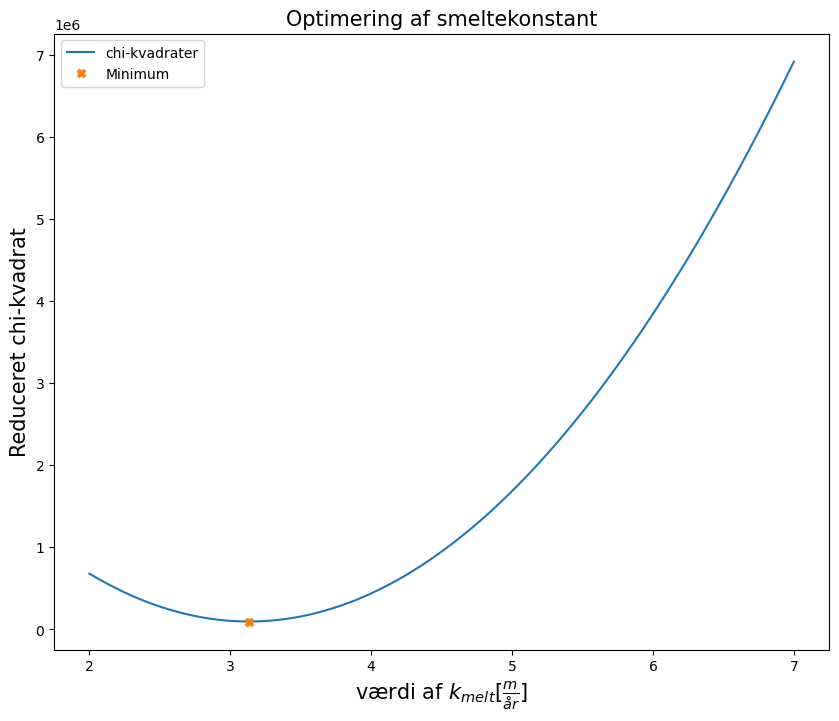

In [60]:
plt.figure(figsize = (10,8))
plt.title('Optimering af smeltekonstant', fontsize = 15)
plt.plot(konstanter_list, chi_list, label = 'chi-kvadrater')
plt.xlabel(r'værdi af $k_{melt} [\frac{m}{år}]$', fontsize = 15)
plt.ylabel('Reduceret chi-kvadrat', fontsize = 15)
plt.plot(konstanter_list[optimal_k_melt_index], chi_list[optimal_k_melt_index], 'X', label = 'Minimum')
plt.legend()

# Plot af simulering sammenlignet med satellitdata for optimale k

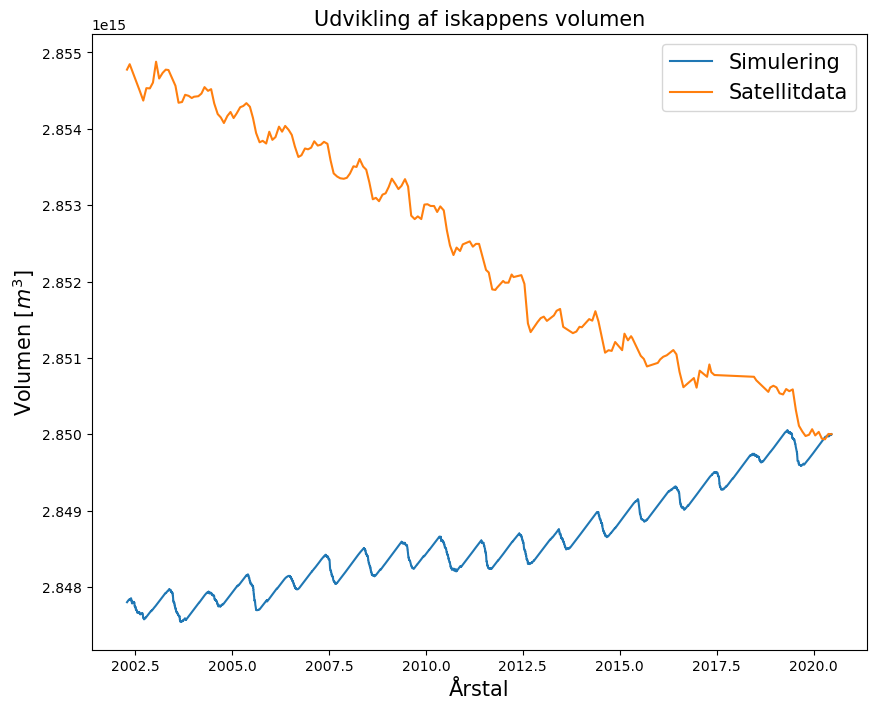

In [61]:
# De globale konstanter defineres
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 2)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
k_melt = konstanter_list[optimal_k_melt_index]  # Smeltekonstanten (Det er denne, vi har varieret på for at få graferne til at overlappe)
# På et år smelter ca. 10 cm ned 
acc = 0.2   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(len(årstal_flip)):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp_flip[i] - T_f <= 0:
        V_melt = 0 
    elif temp_flip[i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp_flip[i] - T_f) * ((T_f - temp_flip[i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V += - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(årstal_flip ,V_list, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)
plt.ylabel(r'Volumen $[m^3]$', fontsize = 15)
plt.title('Udvikling af iskappens volumen', fontsize = 15)

plt.plot(år_sat_flip, dvol_sat_flip + V_0 - dvol_sat_flip[0] , label = 'Satellitdata')
plt.legend(fontsize = 15)
plt.savefig('Simpel iskappesimulering til tuning.png')
